##### Phase 4 – Model Evaluation, Policy Simulation & Deployment Outputs
<small>

**Objective**  

Evaluate model performance, simulate approval policies, and produce deployment-ready outputs for downstream business analysis.

**Key Outcomes**
1. Validate model discrimination and stability across train, validation, and test sets  
2. Translate predicted probabilities into interpretable risk buckets  
3. Simulate conservative, balanced, and aggressive approval strategies  
4. Quantify risk–growth trade-offs using approval volume and loss proxies  
5. Generate a clean, leakage-safe dataset for Power BI dashboards  

**Assumptions**
1. Loan tenure is fixed at one year for all applicants  
2. Predicted PD represents relative default risk over the one-year horizon  
3. Approval policy analysis assumes stable macroeconomic conditions  
4. Expected loss is used as a proxy rather than an absolute loss estimate </small>


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plot


<small> **Data Loading & Feature Construction**

1. Pre-processed training, validation, and test datasets are loaded.
2. A loan burden feature is derived as the ratio of loan amount to income
3. to capture borrower affordability in a scale-invariant manner.</small>


In [14]:

X_train = pd.read_csv("../data/processed/X_train.csv")
X_val   = pd.read_csv("../data/processed/X_val.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")

y_train = pd.read_csv("../data/processed/y_train.csv")["loan_status"]
y_val   = pd.read_csv("../data/processed/y_val.csv")["loan_status"]
y_test  = pd.read_csv("../data/processed/y_test.csv")["loan_status"]

print(X_train.shape, X_val.shape, X_test.shape)
print("Default rates:", y_train.mean(), y_val.mean(), y_test.mean())

for df in [X_train, X_val, X_test]:
    df["loan_burden"] = (df["loan_amnt"] / df["person_income"]).clip(upper=1)



(16694, 13) (3578, 13) (3578, 13)
Default rates: 0.22570983586917456 0.22554499720514254 0.22554499720514254


In [15]:
NUMERIC_COLS = [
    "loan_burden",                 # Primary dominant driver
    "person_emp_length",           # Proxy risk indicator
    "cb_person_cred_hist_length"   # Weak contextual numeric
]


CATEGORICAL_COLS = [
    "person_home_ownership",
    "loan_intent",
    "cb_person_default_on_file"
]


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


<small> **Model Overview**

1. A logistic regression model is used to estimate 1-year Probability of Default (PD).
2. The model is chosen for interpretability and stable risk ordering.
3. Class-weight balancing is applied to address outcome imbalance.</small>


In [17]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_COLS),
        ("cat", categorical_transformer, CATEGORICAL_COLS)
    ]
)
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ]
)


In [18]:
clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

<small> **Model Performance Evaluation**

1. Model performance is evaluated using ROC–AUC and KS statistics
2. across train, validation, and test datasets to assess discrimination
3. and generalization stability.</small>


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_auc(model, X, y, name):
    preds = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, preds)
    print(f"{name} ROC-AUC: {auc:.4f}")
    return preds
train_preds = evaluate_auc(clf, X_train, y_train, "Train")
val_preds   = evaluate_auc(clf, X_val,   y_val,   "Validation")
test_preds  = evaluate_auc(clf, X_test,  y_test,  "Test")

def ks_statistic(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return np.max(tpr - fpr)
print("KS Train:", ks_statistic(y_train, train_preds))
print("KS Val  :", ks_statistic(y_val, val_preds))
print("KS Test :", ks_statistic(y_test, test_preds))


Train ROC-AUC: 0.8006
Validation ROC-AUC: 0.8088
Test ROC-AUC: 0.8158
KS Train: 0.4528504244149204
KS Val  : 0.4655605029431665
KS Test : 0.49294851929414096


In [20]:
ohe = clf.named_steps["preprocessor"] \
         .named_transformers_["cat"] \
         .named_steps["encoder"]

cat_features = ohe.get_feature_names_out(CATEGORICAL_COLS)

feature_names = NUMERIC_COLS + list(cat_features)
coefficients = clf.named_steps["model"].coef_[0]

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients
    })
    .assign(abs_coef=lambda df: df["coefficient"].abs())
    .sort_values("abs_coef", ascending=False)
)

coef_df.head(15)



,feature,coefficient,abs_coef
5,person_home_ownership_OWN,-1.206121,1.206121
0,loan_burden,0.918765,0.918765
6,person_home_ownership_RENT,0.752511,0.752511
13,cb_person_default_on_file_N,-0.639778,0.639778
12,loan_intent_VENTURE,-0.562422,0.562422
14,cb_person_default_on_file_Y,0.488815,0.488815
4,person_home_ownership_OTHER,0.444597,0.444597
9,loan_intent_HOMEIMPROVEMENT,0.375222,0.375222
8,loan_intent_EDUCATION,-0.344827,0.344827
7,loan_intent_DEBTCONSOLIDATION,0.326253,0.326253


In [22]:
# Predict PDs on test set
test_pd = clf.predict_proba(X_test)[:, 1]

pd_df = X_test.copy()
pd_df["loan_status"] = y_test.values
pd_df["pd"] = test_pd

pd_df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_burden,emp_stability,loan_status,pd
0,23,36000,RENT,2.0,VENTURE,C,17500,14.22,0.49,N,4,0.486111,0.086957,1,0.895622
1,24,55200,MORTGAGE,0.0,MEDICAL,D,6000,14.42,0.11,Y,2,0.108696,0.000000,1,0.495216
2,38,140000,MORTGAGE,2.0,MEDICAL,B,8000,10.95,0.06,N,14,0.057143,0.052632,0,0.165236
3,25,14400,RENT,0.0,VENTURE,C,1500,12.99,0.10,Y,2,0.104167,0.000000,1,0.512246
4,24,65000,MORTGAGE,3.0,EDUCATION,B,12000,9.91,0.18,N,4,0.184615,0.125000,0,0.237080


<small> **Risk Bucketing Strategy**

1. Predicted PD values are converted into five ordered risk buckets
2. using quantile-based thresholds learned from the training set.
3. This avoids test-set leakage and ensures consistent bucket definitions.</small>


In [37]:
# Get PDs on TRAIN
train_pd = clf.predict_proba(X_train)[:, 1]

# Learn bucket edges from TRAIN
_, pd_bin_edges = pd.qcut(
    train_pd,
    q=5,
    retbins=True
)
pd_df["risk_bucket"] = pd.cut(
    pd_df["pd"],
    bins=pd_bin_edges,
    labels=[
        "A - Lowest Risk",
        "B - Low Risk",
        "C - Medium Risk",
        "D - High Risk",
        "E - Highest Risk"
    ],
    include_lowest=True
)


<small> **Approval Policy Simulation**

1. Three approval strategies are simulated to evaluate risk–growth trade-offs:
2. conservative, balanced, and aggressive policies progressively expand
3. approval into higher-risk segments.</small>


In [38]:
pd_df["approve_conservative"] = pd_df["risk_bucket"].isin([
    "A - Lowest Risk",
    "B - Low Risk"
]).astype(int)

pd_df["approve_balanced"] = pd_df["risk_bucket"].isin([
    "A - Lowest Risk",
    "B - Low Risk",
    "C - Medium Risk"
]).astype(int)

pd_df["approve_aggressive"] = pd_df["risk_bucket"].isin([
    "A - Lowest Risk",
    "B - Low Risk",
    "C - Medium Risk",
    "D - High Risk"
]).astype(int)


C:\Users\jayra\AppData\Local\Temp\ipykernel_36440\3016609342.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("risk_bucket")


        risk_bucket  applicants    avg_pd  default_rate
0   A - Lowest Risk         715  0.120631      0.034965
1      B - Low Risk         746  0.252136      0.119303
2   C - Medium Risk         705  0.389319      0.130496
3     D - High Risk         683  0.557377      0.202050
4  E - Highest Risk         729  0.805182      0.635117


<Axes: ylabel='risk_bucket'>

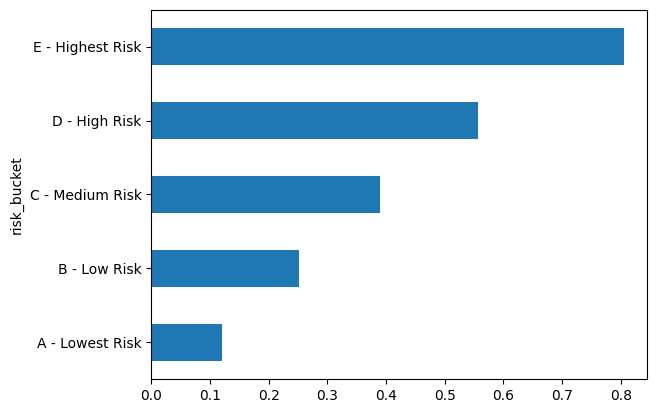

In [39]:
bucket_summary = (
    pd_df
    .groupby("risk_bucket")
    .agg(
        applicants=("pd", "count"),
        avg_pd=("pd", "mean"),
        default_rate=("loan_status", "mean")
    )
    .reset_index()
)

print(bucket_summary)
bucket_summary.plot(x='risk_bucket',y='avg_pd',kind='barh',rot = 0,legend=False)


<Axes: title={'center': 'Observed Default Rate by Risk Bucket'}, ylabel='risk_bucket'>

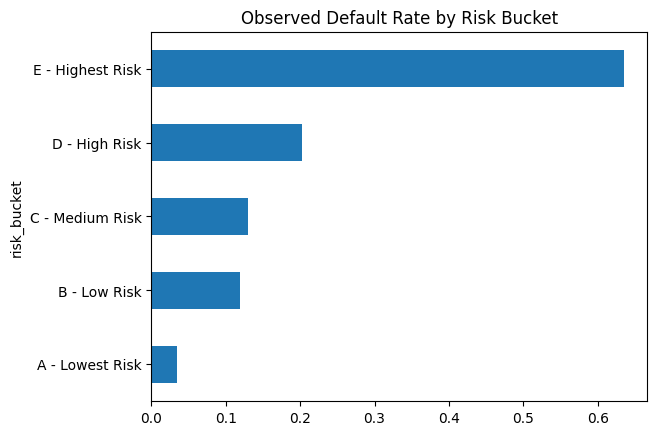

In [42]:
bucket_summary.plot(
    x="risk_bucket",
    y="default_rate",
    kind="barh",
    title="Observed Default Rate by Risk Bucket",
    legend=False
)


##### Balanced Policy Threshold Analysis (Bucket C)


In [55]:
bucket_c_df = pd_df[pd_df["risk_bucket"] == "C - Medium Risk"]
bucket_c_df.shape

mean_pd = bucket_c_df["pd"].mean()
median_pd = bucket_c_df["pd"].median()

mean_pd, median_pd


(np.float64(0.3893188419071953), np.float64(0.39025576182559685))

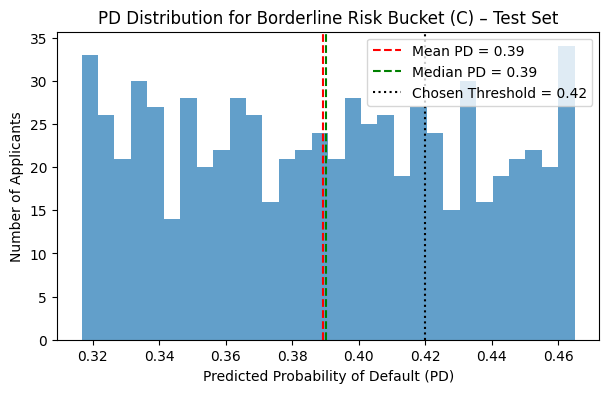

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))

plt.hist(
    bucket_c_df["pd"],
    bins=30,
    alpha=0.7
)

plt.axvline(mean_pd, color="red", linestyle="--", label=f"Mean PD = {mean_pd:.2f}")
plt.axvline(median_pd, color="green", linestyle="--", label=f"Median PD = {median_pd:.2f}")
plt.axvline(0.42, color="black", linestyle=":", label="Chosen Threshold = 0.42")

plt.xlabel("Predicted Probability of Default (PD)")
plt.ylabel("Number of Applicants")
plt.title("PD Distribution for Borderline Risk Bucket (C) – Test Set")
plt.legend()

plt.show()


<small> **Observation**

The PD distribution within bucket C is approximately symmetric, with mean and median
values closely aligned. This indicates limited skew<br> from extreme values and suggests that
a central cutoff is representative of typical risk in this segment.<small>

In [40]:
def policy_metrics(df, col):
    approved = df[df[col] == 1]
    return {
        "approval_rate": approved.shape[0] / df.shape[0],
        "default_rate_approved": approved["loan_status"].mean(),
        "num_approved": approved.shape[0]
    }
policy_summary = pd.DataFrame({
    "Conservative": policy_metrics(pd_df, "approve_conservative"),
    "Balanced": policy_metrics(pd_df, "approve_balanced"),
    "Aggressive": policy_metrics(pd_df, "approve_aggressive")
}).T

policy_summary


,approval_rate,default_rate_approved,num_approved
Conservative,0.408329,0.078029,1461.0
Balanced,0.605366,0.095106,2166.0
Aggressive,0.796255,0.120744,2849.0


<small> **Expected Loss Proxy**

1. Expected loss is approximated as the sum of predicted PDs for approved applicants.
2. This serves as a relative risk proxy for comparing approval strategies and is not a full loss model.</small>


In [41]:
def expected_loss(df, col):
    return df.loc[df[col] == 1, "pd"].sum()

el_summary = pd.DataFrame({
    "expected_loss": [
        expected_loss(pd_df, "approve_conservative"),
        expected_loss(pd_df, "approve_balanced"),
        expected_loss(pd_df, "approve_aggressive")
    ]
}, index=["Conservative", "Balanced", "Aggressive"])

el_summary


,expected_loss
Conservative,274.344495
Balanced,548.814279
Aggressive,929.502566


In [43]:
DROP_COLS = [
    "loan_status",          # target (post-outcome)
    "loan_int_rate",        # post-risk pricing
    "loan_percent_income", # redundant / post-processed
    "approved"              # legacy single-policy column
]
PBI_COLS = [
    "person_age",
    "person_income",
    "person_home_ownership",
    "person_emp_length",
    "loan_intent",
    "loan_amnt",
    "cb_person_default_on_file",
    "cb_person_cred_hist_length",
    "loan_burden",
    "pd",
    "risk_bucket",
    "approve_conservative",
    "approve_balanced",
    "approve_aggressive"
]


<small> **Deployment-Ready Output**

1. A clean, leakage-safe dataset is prepared for Power BI consumption.
2. Post-outcome fields are removed, approval flags are encoded explicitly.
3. Numeric types are enforced for visualization compatibility.</small>


In [ ]:

pbi_df = pd_df.drop(columns=[c for c in DROP_COLS if c in pd_df.columns])
pbi_df = pbi_df[PBI_COLS]

# Approval flags to int
for col in ["approve_conservative", "approve_balanced", "approve_aggressive"]:
    pbi_df[col] = pbi_df[col].astype("int64")

# Numeric fields to float
pbi_df["pd"] = pbi_df["pd"].astype("float64")
pbi_df["loan_burden"] = pbi_df["loan_burden"].astype("float64")

pbi_df["person_income"] = pbi_df["person_income"].astype("int64")
pbi_df["loan_amnt"] = pbi_df["loan_amnt"].astype("int64")


In [50]:


# Export for Power BI
pbi_df.to_csv(
    "../data/processed/pd_scoring_output_pbi.csv",
    index=False
)


